## Early Fusion Multi-Modal Classifier 

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import os
import PIL
import sklearn
import pickle
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras

In [ ]:
from utils import data_utils, model_utils, models

#### Data Loading and Pre-processing

In [ ]:
label_map = label_map = {
    'geol_geow': 0, 
    'geol_sed': 1, 
    'gphys_gen': 2, 
    'log_sum': 3, 
    'pre_site': 4, 
    'vsp_file': 5
}

In [16]:
doc_data = data_utils.DocumentData(label_map, 2020, drop_nans='or')

In [18]:
doc_data.load_text_data()
doc_data.text_train.shape

(4177, 2000)

In [21]:
doc_data.load_image_data(image_size=200, n_pages=10)
doc_data.image_train.shape

(4177, 10, 200, 200, 1)

In [22]:
text_train = np.array([np.array([text] * 10) for text in doc_data.text_train])
text_val = np.array([np.array([text] * 10) for text in doc_data.text_val])
text_test = np.array([np.array([text] * 10) for text in doc_data.text_test])

#### Early Fusion C-LSTM Classifier

Text modality feature extraction:

In [77]:
text_input = keras.layers.Input(shape=(10, 2000), name='text_input')
embeddings = keras.layers.TimeDistributed(keras.layers.Embedding(doc_data.vocab_length, 150, input_length=2000), name='word_embeddings')(text_input)
conv_1d = keras.layers.TimeDistributed(keras.layers.Conv1D(filters=200, kernel_size=7, activation='relu'), name='1d_convolutional_layer')(embeddings)
global_pooling = keras.layers.TimeDistributed(keras.layers.GlobalMaxPool1D(), name='max_pooling_layer')(conv_1d)
image_features = keras.layers.TimeDistributed(keras.layers.Flatten(), name='text_features')(global_pooling)

Image modality feature extraction:

In [78]:
image_input = keras.layers.Input(shape=(10, 200, 200, 1), name='image_input')
conv_2d_1 = keras.layers.TimeDistributed(keras.layers.Conv2D(20, 7, activation='relu', padding='same'), name='2d_convolutional_layer_1')(image_input)
pool_2d_1 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4), name='2d_max_pooling_layer_1')(conv_2d_1)
conv_2d_2 = keras.layers.TimeDistributed(keras.layers.Conv2D(50, 5, activation='relu', padding='valid'), name='2d_convolutional_layer_2')(pool_2d_1)
pool_2d_2 = keras.layers.TimeDistributed(keras.layers.MaxPooling2D(4), name='2d_max_pooling_layer_2')(conv_2d_2)
text_features = keras.layers.TimeDistributed(keras.layers.Flatten(), name='image_features')(pool_2d_2)

Joint feature representation:

In [79]:
joint_features = keras.layers.concatenate([text_features, image_features])

Classifier layers:

In [80]:
lstm_1 = keras.layers.LSTM(450, return_sequences=True)(joint_features)
lstm_2 = keras.layers.LSTM(1000)(lstm_1)
dropout = keras.layers.Dropout(0.5)(lstm_2)
output = keras.layers.Dense(6, activation='softmax')(dropout)

Build and compile model:

In [81]:
model = keras.models.Model(inputs=[text_input, image_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 10, 200, 200 0                                            
__________________________________________________________________________________________________
2d_convolutional_layer_1 (TimeD (None, 10, 200, 200, 1000        image_input[0][0]                
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 10, 2000)]   0                                            
__________________________________________________________________________________________________
2d_max_pooling_layer_1 (TimeDis (None, 10, 50, 50, 2 0           2d_convolutional_layer_1[0][0]   
______________________________________________________________________________________

Train and evaluate model:

In [83]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [84]:
history = model.fit(
    [text_train, doc_data.image_train], 
    doc_data.y_train, 
    epochs=400, 
    validation_data=([text_val, doc_data.image_val], doc_data.y_val), 
    callbacks=[early_stopping]
)

Epoch 1/400
131/131 [==============================] - 140s 1s/step - loss: 1.3085 - accuracy: 0.4814 - val_loss: 0.8034 - val_accuracy: 0.7091
Epoch 2/400
131/131 [==============================] - 122s 933ms/step - loss: 0.6202 - accuracy: 0.7711 - val_loss: 0.6621 - val_accuracy: 0.7560
Epoch 3/400
131/131 [==============================] - 122s 933ms/step - loss: 0.3708 - accuracy: 0.8738 - val_loss: 0.6844 - val_accuracy: 0.7675
Epoch 4/400
131/131 [==============================] - 116s 885ms/step - loss: 0.2695 - accuracy: 0.9131 - val_loss: 0.6955 - val_accuracy: 0.7656


In [57]:
model.evaluate([text_test, doc_data.image_test], doc_data.y_test)

41/41 [==============================] - 13s 316ms/step - loss: 0.6578 - accuracy: 0.7818


[0.6578467488288879, 0.7817764282226562]

In [ ]:
y_hat = model.predict([text_test, doc_data.image_test])

In [ ]:
y = np.argmax(doc_data.y_test, axis=-1)

In [ ]:
labels = [label for label in label_map]
print(metrics.classification_report(y, y_hat, target_names=labels))

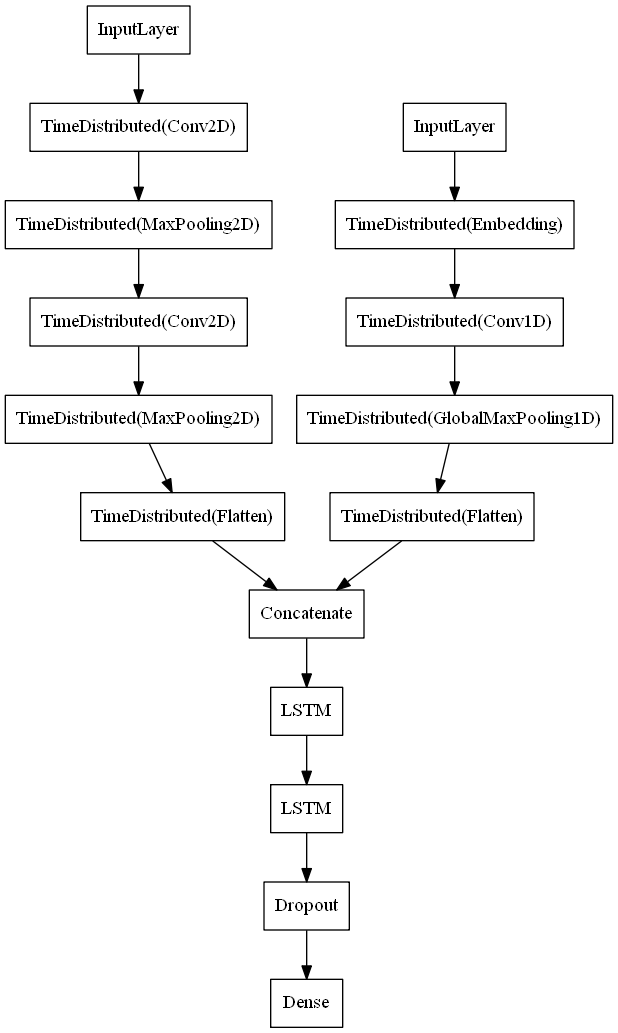

In [67]:
keras.utils.plot_model(model, show_layer_names=False)